**Importing data**

In [62]:
# Importing pandas for making data frames
import pandas as pd
import numpy as np

In [63]:
tweets_raw = pd.read_csv('https://raw.githubusercontent.com/MariaRosendal/Tesla-tweets/main/tweets.csv')

In [64]:
tweets_raw.head()

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,tweet,language,mentions,urls,photos,replies_count,retweets_count,likes_count,hashtags,cashtags,link,retweet,quote_url,video,thumbnail,near,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
0,1328458535340949505,1328428879334297600,2020-11-16 22:02:51 UTC,2020-11-16,22:02:51,0,44196397,elonmusk,Elon Musk,NaN,@Maisie_Williams 🎶 Toss a bitcoin to ur Witcher 🎶,en,[],[],[],1148,3448,66981,[],[],https://twitter.com/elonmusk/status/1328458535...,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'Maisie_Williams', 'name': 'M...",NaN,NaN,NaN,NaN
1,1328451518010327042,1328143001697230848,2020-11-16 21:34:57 UTC,2020-11-16,21:34:57,0,44196397,elonmusk,Elon Musk,NaN,@Kristennetten 😉,und,[],[],[],100,37,2203,[],[],https://twitter.com/elonmusk/status/1328451518...,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'Kristennetten', 'name': 'K10...",NaN,NaN,NaN,NaN
2,1328424097110323200,1328352029190877185,2020-11-16 19:46:00 UTC,2020-11-16,19:46:00,0,44196397,elonmusk,Elon Musk,NaN,"@WhatsupFranks @michaelmina_lab CureVac, Moder...",en,[],[],[],72,75,1090,[],[],https://twitter.com/elonmusk/status/1328424097...,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'WhatsupFranks', 'name': 'fra...",NaN,NaN,NaN,NaN
3,1328421992144355328,1328352029190877185,2020-11-16 19:37:38 UTC,2020-11-16,19:37:38,0,44196397,elonmusk,Elon Musk,NaN,@michaelmina_lab Creating synthetic mRNA for c...,en,[],[],[],96,90,1221,[],[],https://twitter.com/elonmusk/status/1328421992...,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'michaelmina_lab', 'name': 'M...",NaN,NaN,NaN,NaN
4,1328419837656276992,1328338500064845825,2020-11-16 19:29:04 UTC,2020-11-16,19:29:04,0,44196397,elonmusk,Elon Musk,NaN,@gaertner_anne @Neuro_Skeptic @DresdenTea @jud...,tl,[],[],[],55,32,1412,[],[],https://twitter.com/elonmusk/status/1328419837...,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'gaertner_anne', 'name': 'Ann...",NaN,NaN,NaN,NaN


In [65]:
tweets_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10230 entries, 0 to 10229
Data columns (total 36 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               10230 non-null  int64  
 1   conversation_id  10230 non-null  int64  
 2   created_at       10230 non-null  object 
 3   date             10230 non-null  object 
 4   time             10230 non-null  object 
 5   timezone         10230 non-null  int64  
 6   user_id          10230 non-null  int64  
 7   username         10230 non-null  object 
 8   name             10230 non-null  object 
 9   place            0 non-null      float64
 10  tweet            10230 non-null  object 
 11  language         10230 non-null  object 
 12  mentions         10230 non-null  object 
 13  urls             10230 non-null  object 
 14  photos           10230 non-null  object 
 15  replies_count    10230 non-null  int64  
 16  retweets_count   10230 non-null  int64  
 17  likes_count 

In [66]:
tweets_raw.describe().round(2)

,id,conversation_id,timezone,user_id,place,replies_count,retweets_count,likes_count,video,near,geo,source,user_rt_id,user_rt,retweet_id,retweet_date,translate,trans_src,trans_dest
count,1.023000e+04,1.023000e+04,10230.0,10230.0,0.0,10230.00,10230.00,10230.00,10230.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,1.093816e+18,1.091027e+18,0.0,44196397.0,NaN,557.39,2226.22,19569.01,0.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,1.653157e+17,1.701199e+17,0.0,0.0,NaN,1932.38,10115.00,59726.37,0.23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,6.675167e+17,1.659576e+09,0.0,44196397.0,NaN,0.00,0.00,57.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,1.000081e+18,9.993676e+17,0.0,44196397.0,NaN,47.00,44.00,1018.25,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,1.119283e+18,1.117901e+18,0.0,44196397.0,NaN,110.00,129.00,2625.50,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,1.238623e+18,1.237239e+18,0.0,44196397.0,NaN,376.00,858.50,11936.25,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,1.328459e+18,1.328429e+18,0.0,44196397.0,NaN,47526.00,372865.00,1638662.00,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Cleaning the data

In [67]:
# Create dataframe with relevant columns
elon_musk_raw = tweets_raw.loc[:,['date', 'tweet', 'retweets_count']]
elon_musk_raw

,date,tweet,retweets_count
0,2020-11-16,@Maisie_Williams 🎶 Toss a bitcoin to ur Witcher 🎶,3448
1,2020-11-16,@Kristennetten 😉,37
2,2020-11-16,"@WhatsupFranks @michaelmina_lab CureVac, Moder...",75
3,2020-11-16,@michaelmina_lab Creating synthetic mRNA for c...,90
4,2020-11-16,@gaertner_anne @Neuro_Skeptic @DresdenTea @jud...,32
...,...,...,...
10225,2015-11-20,@StartupLJackson Yeah and hell yeah,94
10226,2015-11-20,@atduarte From anywhere,24
10227,2015-11-20,Should mention that I will be interviewing peo...,1552
10228,2015-11-20,We are looking for hardcore software engineers...,3932


In [68]:
# Make dates to datetime format
elon_musk_raw['date'] = pd.to_datetime(elon_musk_raw.date)

In [69]:
# Set the date as index
elon_musk_raw.set_index('date', inplace=True)

In [70]:
# Let's have a look
elon_musk_raw

,tweet,retweets_count
date,,
2020-11-16,@Maisie_Williams 🎶 Toss a bitcoin to ur Witcher 🎶,3448
2020-11-16,@Kristennetten 😉,37
2020-11-16,"@WhatsupFranks @michaelmina_lab CureVac, Moder...",75
2020-11-16,@michaelmina_lab Creating synthetic mRNA for c...,90
2020-11-16,@gaertner_anne @Neuro_Skeptic @DresdenTea @jud...,32
...,...,...
2015-11-20,@StartupLJackson Yeah and hell yeah,94
2015-11-20,@atduarte From anywhere,24
2015-11-20,Should mention that I will be interviewing peo...,1552


In [71]:
# Removing bottom 10% tweets with the least retweets per year (as they have been seen by few and will have little effect on the stock price)

# Defining x for when tweets are retweeted may than bottom 10% retweets (for every year)
for year in elon_musk_raw.index.year:
  x = (elon_musk_raw.retweets_count > elon_musk_raw.retweets_count.quantile(0.1))

# Create column with top retweets (True if rows are to be keept)
elon_musk_raw['top_retweets'] = x

# Keep only top tweets with most retweets (i.e drop rows with bottom 10% retweets)
elon_musk = elon_musk_raw[elon_musk_raw['top_retweets']== True].copy() 

## Remove top retweets column (no longer needed)
elon_musk.drop('top_retweets', axis=1, inplace=True)

In [72]:
elon_musk.shape

(9144, 2)

# Tweet preprosessing for topic modelling

In [73]:
# Importing packages for text preprocessing
import nltk

# Importing tokenizing
from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer()

# Importing  stopwords 
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# Importing punctuations
nltk.download('punkt')
from string import punctuation

# Spacy
import spacy
nlp = spacy.load("en")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [74]:
# Installing preprocessor
!pip install tweet-preprocessor

In [75]:
# Importing preprocessor
import preprocessor as p

In [76]:
#Setting options for the cleaner to delete from the tweet
p.set_options(p.OPT.RESERVED, p.OPT.URL, p.OPT.EMOJI, p.OPT.SMILEY, p.OPT.NUMBER, p.OPT.HASHTAG)

In [77]:
# Cleaning the tweets
elon_musk['tweet_clean'] = [p.clean(tweet) for tweet in elon_musk['tweet']]

In [78]:
# Remove punctuations
cleanup_punctuations = list(set(punctuation))

for punc in cleanup_punctuations:
    elon_musk["tweet_clean"] = [tweet.replace(punc, "") for tweet in elon_musk["tweet_clean"]]

In [79]:
# Let's see if it worked (it did)
elon_musk.head()

,tweet,retweets_count,tweet_clean
date,,,
2020-11-16,@Maisie_Williams 🎶 Toss a bitcoin to ur Witcher 🎶,3448,MaisieWilliams Toss a bitcoin to ur Witcher
2020-11-16,@Kristennetten 😉,37,Kristennetten
2020-11-16,"@WhatsupFranks @michaelmina_lab CureVac, Moder...",75,WhatsupFranks michaelminalab CureVac Moderna a...
2020-11-16,@michaelmina_lab Creating synthetic mRNA for c...,90,michaelminalab Creating synthetic mRNA for cur...
2020-11-16,@gaertner_anne @Neuro_Skeptic @DresdenTea @jud...,32,gaertneranne NeuroSkeptic DresdenTea judithher...


In [80]:
# Remove amp (a twitter component that is not in the actual tweet)
elon_musk['tweet_clean'] = elon_musk['tweet_clean'].replace('amp','', regex=True)

In [81]:
# Create list with lemmatized tokens, only incl. nouns, pronouns and adjectives
tokens = []

for tweet in nlp.pipe(elon_musk['tweet_clean']):
  tweet_tok = [token.lemma_.lower() for token in tweet if token.pos_ in ['PROPN', 'NOUN', 'ADJ']] 
  tokens.append(tweet_tok)

In [82]:
# Make a token column
elon_musk['tokens'] = tokens

In [83]:
# Removing stopwords

elon_musk['tokens'] = elon_musk['tokens'].apply(lambda x: [token for token in x if token not in stop_words])

In [84]:
# Keep only words with more than 2 letters
elon_musk['tokens'] = elon_musk['tokens'].apply(lambda x: [word for word in x if len(word) > 2])

In [85]:
# Showing if tokenization worked properly
elon_musk.head()

,tweet,retweets_count,tweet_clean,tokens
date,,,,
2020-11-16,@Maisie_Williams 🎶 Toss a bitcoin to ur Witcher 🎶,3448,MaisieWilliams Toss a bitcoin to ur Witcher,"[maisiewilliams, toss, bitcoin, witcher]"
2020-11-16,@Kristennetten 😉,37,Kristennetten,[kristennetten]
2020-11-16,"@WhatsupFranks @michaelmina_lab CureVac, Moder...",75,WhatsupFranks michaelminalab CureVac Moderna ...,"[whatsupfranks, michaelminalab, curevac, moder..."
2020-11-16,@michaelmina_lab Creating synthetic mRNA for c...,90,michaelminalab Creating synthetic mRNA for cur...,"[michaelminalab, synthetic, mrna, curesvaccine..."
2020-11-16,@gaertner_anne @Neuro_Skeptic @DresdenTea @jud...,32,gaertneranne NeuroSkeptic DresdenTea judithher...,"[gaertneranne, neuroskeptic, dresdentea, judit..."


In [86]:
# Make tokens into string
elon_musk["tweet_clean_string"] = elon_musk["tokens"].map(lambda row: " ".join(row))

In [87]:
# Removing empty rows in tweet_clean_string
elon_musk['tweet_clean_string'].replace("",float("NaN"), inplace=True)
elon_musk.dropna(subset = ['tweet_clean_string'], inplace=True)

In [88]:
# Let's see what it looks like now
elon_musk.head(10)

,tweet,retweets_count,tweet_clean,tokens,tweet_clean_string
date,,,,,
2020-11-16,@Maisie_Williams 🎶 Toss a bitcoin to ur Witcher 🎶,3448,MaisieWilliams Toss a bitcoin to ur Witcher,"[maisiewilliams, toss, bitcoin, witcher]",maisiewilliams toss bitcoin witcher
2020-11-16,@Kristennetten 😉,37,Kristennetten,[kristennetten],kristennetten
2020-11-16,"@WhatsupFranks @michaelmina_lab CureVac, Moder...",75,WhatsupFranks michaelminalab CureVac Moderna ...,"[whatsupfranks, michaelminalab, curevac, moder...",whatsupfranks michaelminalab curevac moderna t...
2020-11-16,@michaelmina_lab Creating synthetic mRNA for c...,90,michaelminalab Creating synthetic mRNA for cur...,"[michaelminalab, synthetic, mrna, curesvaccine...",michaelminalab synthetic mrna curesvaccine fut...
2020-11-16,@gaertner_anne @Neuro_Skeptic @DresdenTea @jud...,32,gaertneranne NeuroSkeptic DresdenTea judithher...,"[gaertneranne, neuroskeptic, dresdentea, judit...",gaertneranne neuroskeptic dresdentea judithherber
2020-11-16,@michaelmina_lab Great thread,40,michaelminalab Great thread,"[michaelminalab, great, thread]",michaelminalab great thread
2020-11-16,"@SamTalksTesla I’m ok, thanks for asking. No s...",120,SamTalksTesla Im ok thanks for asking No sympt...,"[samtalkstesla, thank, symptom, past, day, fat...",samtalkstesla thank symptom past day fatigue c...
2020-11-16,Launch in 5 minutes,4932,Launch in minutes,[minute],minute
2020-11-16,"@flcnhvy Yeah, with cooling channels integrate...",86,flcnhvy Yeah with cooling channels integrated ...,"[flcnhvy, channel, chamber, wall]",flcnhvy channel chamber wall


In [ ]:
# Install packages for making word cloud
!pip install wordcloud
from wordcloud import WordCloud

# Install packages for mask setting
from PIL import Image
import urllib.request

#For visualization 
import matplotlib.pyplot as plt

In [90]:
# Load wordcloud mask from github
twitter_bird = urllib.request.urlopen("https://raw.githubusercontent.com/MariaRosendal/Tesla-tweets/main/twitter_mask.png")

In [60]:
# Create mask
mask = np.array(Image.open(twitter_bird))

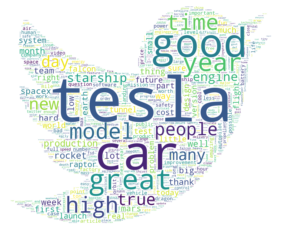

In [61]:
#Visualize wordcloud 

wc = WordCloud(
    mask = mask, background_color="white",
    max_words=2000, max_font_size=256,
    random_state=42, width=mask.shape[1],
    height=mask.shape[0])
wc.generate(' '.join(elon_musk['tweet_clean_string']))
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.show()

# Creating Corpus and Dictionary

We can now create a corpus of the tweets as they have been cleaned and transformed to tokens. To do so, we have used Gensim and converted the tokens to a dictionary.

In [149]:
# Installing gensim
!pip install -qq -U gensim

In [150]:
# Importing gensim library and dictionary
import gensim
from gensim.corpora.dictionary import Dictionary

In [151]:
# Creating dictionary
dictionary = Dictionary(elon_musk['tokens'])

In [152]:
# Filter out extremes (tokens that appear in less than 20 tweets and tokens included in every other tweeet)
dictionary.filter_extremes(no_below=20, no_above=0.5)

In [153]:
# Let's see the corresponding ID for top 10 tokens in the dictionary
list(dictionary.token2id.items())[:10]

[('kristennetten', 0),
 ('few', 1),
 ('machine', 2),
 ('other', 3),
 ('tesla', 4),
 ('future', 5),
 ('problem', 6),
 ('software', 7),
 ('great', 8),
 ('change', 9)]

In [154]:
# Creating a corpus from the dictionary (a list of tuples, with word-IDs and the number of their occurrence in tweets)
corpus = [dictionary.doc2bow(doc) for doc in elon_musk['tokens']]

#Topic modelling using LDA

**Finding optimal number of topics using coherence value**

In [155]:
#I mporting the LDA model
from gensim.models import LdaMulticore

# Importing coherence model
from gensim.models.coherencemodel import CoherenceModel

In [174]:
# Converting all columns with tokens to one list
tokens_list = elon_musk['tokens'].to_list()

In [229]:
# Define function to find the optimal number of topics using the coherence score
def compute_coherence_values(corpus, dictionary, texts, limit, start, step):
    coherence_values = []
    model_list = []
    for num in range(start, limit, step):
        model = LdaMulticore(corpus=corpus, 
                                       id2word=dictionary, 
                                       num_topics=num,
                                       random_state=50,
                                       chunksize=200,
                                       passes=1)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=tokens_list, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [230]:
# Running above function (from 2 to 40 topics, calculating coherence score for every fourth number of topics)
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=tokens_list, start=2, limit=40, step=4)

In [231]:
# Importing matplotlib for visualization
import matplotlib.pyplot as plt 
%matplotlib inline

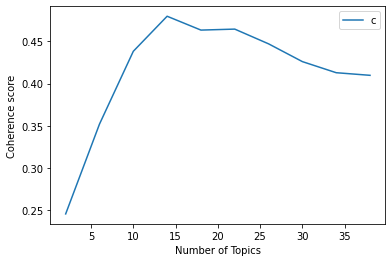

In [232]:
# Visualizing topic models and their coherence score
limit=40; start=2; step=4;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [233]:
# Let's have a look at the number of topics and their corresponding coherence score
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 2))

Num Topics = 2  has Coherence Value of 0.25
Num Topics = 6  has Coherence Value of 0.35
Num Topics = 10  has Coherence Value of 0.44
Num Topics = 14  has Coherence Value of 0.48
Num Topics = 18  has Coherence Value of 0.46
Num Topics = 22  has Coherence Value of 0.46
Num Topics = 26  has Coherence Value of 0.45
Num Topics = 30  has Coherence Value of 0.43
Num Topics = 34  has Coherence Value of 0.41
Num Topics = 38  has Coherence Value of 0.41


We see that 14 is the optimal number of topics as it has the highest coherence score before a major decline

**LDA model with optimal number of topics**

In [226]:
# Defining the LDA parameters with optimal number of topics
lda_model_best = LdaMulticore(corpus=corpus, 
                                       id2word=dictionary, 
                                       num_topics=14,
                                       random_state=50,
                                       chunksize=200,
                                       passes=1)

In [227]:
# Printing topics from the optimal LDA model
lda_model_best.print_topics(-1)

[(0,
  '0.104*"first" + 0.068*"system" + 0.054*"many" + 0.053*"battery" + 0.049*"new" + 0.044*"air" + 0.038*"dragon" + 0.033*"support" + 0.029*"time" + 0.028*"piece"'),
 (1,
  '0.090*"team" + 0.086*"day" + 0.084*"tesla" + 0.069*"thing" + 0.044*"california" + 0.044*"last" + 0.035*"safety" + 0.034*"well" + 0.030*"work" + 0.026*"story"'),
 (2,
  '0.166*"year" + 0.153*"next" + 0.103*"spacex" + 0.066*"nasa" + 0.065*"software" + 0.044*"unveil" + 0.042*"long" + 0.042*"life" + 0.039*"bad" + 0.035*"number"'),
 (3,
  '0.144*"landing" + 0.122*"launch" + 0.093*"great" + 0.075*"cape" + 0.051*"min" + 0.043*"point" + 0.042*"world" + 0.039*"hour" + 0.033*"night" + 0.030*"product"'),
 (4,
  '0.092*"same" + 0.091*"big" + 0.078*"week" + 0.071*"production" + 0.056*"tomorrow" + 0.049*"update" + 0.049*"change" + 0.043*"person" + 0.041*"dmcryan" + 0.029*"early"'),
 (5,
  '0.153*"falcon" + 0.103*"autopilot" + 0.054*"way" + 0.045*"heavy" + 0.045*"part" + 0.042*"real" + 0.034*"energy" + 0.031*"tesla" + 0.031*"o

How to interpret this: It means the top 10 keywords that contribute to topic 8 (topic 7 when starting at 0) are: ‘tesla', ‘car', 'autopilot'... and so on, and the weight of ‘tesla' in topic 8 is 0.310.

In [234]:
# Evaluating the best LDA model on other performance measures than coherence

# Compute Perplexity score
print('\nPerplexity: ', lda_model_best.log_perplexity(corpus))  # (the lower the better the model)


Perplexity:  -6.8844720045298695


**Visualizing LDA topics**

In [235]:
# Installing pyLDavis
!pip install -qq pyLDAvis

# Importing packages for visualization of topics
import pyLDAvis
import pyLDAvis.gensim

In [236]:
# Visualizing the topics
graph_lda = pyLDAvis.gensim.prepare(lda_model_best, corpus, dictionary)
pyLDAvis.display(graph_lda)

# Topic modelling using LDA Mallet

**Finding optimal number of topics**

In [ ]:
# Importing mallet package
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip  

mallet_path = '/content/mallet-2.0.8/bin/mallet'

In [238]:
# Define function to find the optimal number of topics using the coherence score
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=dictionary, random_seed = 100)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=tokens_list, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [239]:
# Running above function (from 2 to 40 topics, calculating coherence score for every fourth number of topics)
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=tokens_list, start=2, limit=30, step=4)

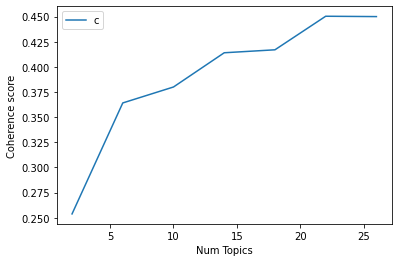

In [240]:
# Visualizing topic models and their coherence score
limit=30; start=2; step=4;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [241]:
# Let's have a look at the number of topics and their corresponding coherence score
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 2))

Num Topics = 2  has Coherence Value of 0.25
Num Topics = 6  has Coherence Value of 0.36
Num Topics = 10  has Coherence Value of 0.38
Num Topics = 14  has Coherence Value of 0.41
Num Topics = 18  has Coherence Value of 0.42
Num Topics = 22  has Coherence Value of 0.45
Num Topics = 26  has Coherence Value of 0.45


The marginal coherence score decreases after 18 topics. Thus, we argue that this is the best number of topics.

**LDA Mallet model with optimal number of topics**

In [242]:
# Defining the LDA Mallet parameters with optimal number of topics
ldamallet_best = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=dictionary, random_seed=100)

In [243]:
# Show Topics(note that Mallet does not sort the topics from 0 to 18)
print(ldamallet_best.show_topics(formatted=False))

[(0, [('tesla', 0.26102502979737785), ('time', 0.10409217322208979), ('teslarati', 0.057210965435041714), ('autopilot', 0.04012713547874454), ('full', 0.03972983710766786), ('evafoxu', 0.026618990862137464), ('short', 0.025824394119984106), ('case', 0.02542709574890743), ('important', 0.025029797377830752), ('china', 0.023837902264600714)]), (1, [('high', 0.09371428571428571), ('people', 0.07885714285714286), ('true', 0.06819047619047619), ('big', 0.052571428571428575), ('company', 0.05142857142857143), ('thing', 0.04495238095238095), ('future', 0.03695238095238095), ('world', 0.03504761904761905), ('real', 0.029714285714285714), ('energy', 0.029333333333333333)]), (2, [('good', 0.1560898699251084), ('month', 0.05439495467087111), ('cleantechnica', 0.05281828931809224), ('nasa', 0.039416633819471816), ('software', 0.03823413480488766), ('today', 0.028774142688214426), ('dragon', 0.02640914465904612), ('nichegamer', 0.023649980291683092), ('twitter', 0.023255813953488372), ('video', 0.0

**Conclusion**: In general, the LDA is better than the LDA Mallet model based on coherence score. Thus, we use the classical LDA model.

# Defining and exploring topics

In [244]:
# Creating dataframe for LDA topics 
topics = [[(term, round(wt, 3)) for term, wt in lda_model_best.show_topic(n, topn=10)] for n in range(0, lda_model_best.num_topics)]

lda_topics_df = pd.DataFrame([', '.join([term for term, wt in topic]) for topic in topics], columns = ['Terms in Topic'], index=['Topic'+str(t) for t in range(1, lda_model_best.num_topics+1)] )

lda_topics_df

,Terms in Topic
Topic1,"first, system, many, battery, new, air, dragon..."
Topic2,"team, day, tesla, thing, california, last, saf..."
Topic3,"year, next, spacex, nasa, software, unveil, lo..."
Topic4,"landing, launch, great, cape, min, point, worl..."
Topic5,"same, big, week, production, tomorrow, update,..."
Topic6,"falcon, autopilot, way, heavy, part, real, ene..."
Topic7,"tesla, car, video, order, mile, model, electri..."
Topic8,"more, people, company, space, tunnel, fire, lo..."
Topic9,"model, month, full, few, booster, tonight, nam..."
Topic10,"article, high, engine, flight, level, orbital,..."


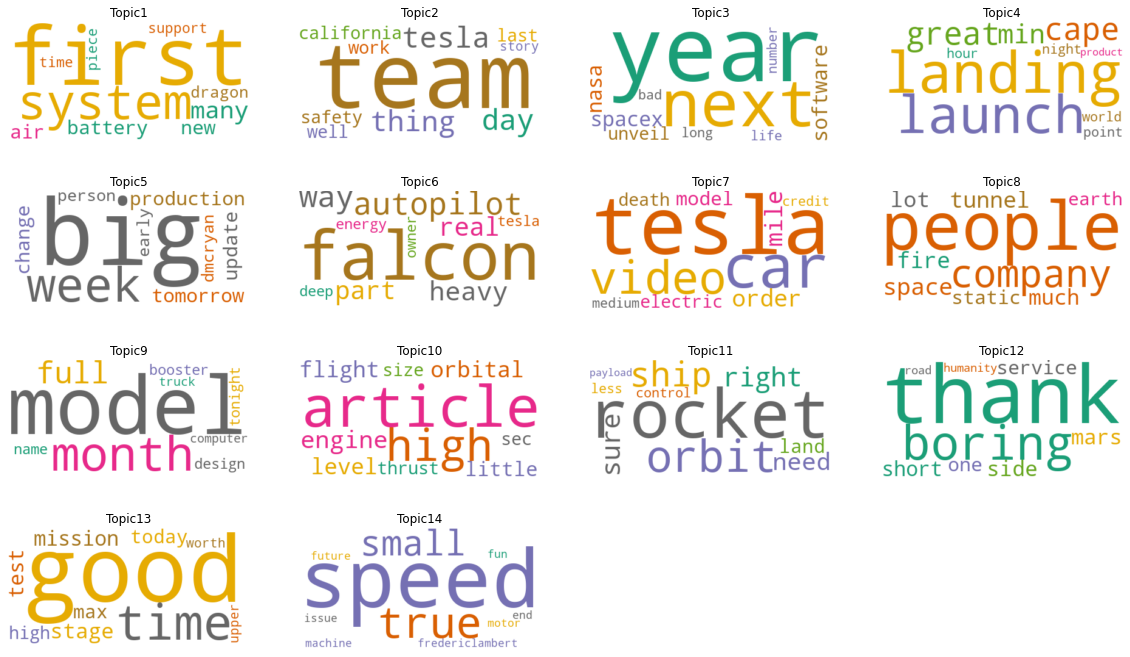

In [245]:
# Import wordcloud
from wordcloud import WordCloud
import matplotlib.colors as mcolors

# Defining the wordcloud object
wc = WordCloud(background_color="white", colormap="Dark2", max_font_size=150, random_state=42)

# Setting the figure size
plt.rcParams['figure.figsize'] = [20, 15]

# Create subplots for each topic
for i in range(14):
    wc.generate(text=lda_topics_df["Terms in Topic"][i])
    
    plt.subplot(5, 4, i+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(lda_topics_df.index[i])
plt.show()

#(Toping moddeling using LSI - not included in paper)

In [246]:
# Importing TfidfModel and LSI
from gensim.models.tfidfmodel import TfidfModel
from gensim.models.lsimodel import LsiModel

In [247]:
# Creating Tfidf corpus
tfidf = TfidfModel(corpus)
tfidf_corpus = tfidf[corpus]

In [248]:
# Creating the LSI model with the tfidf_corpus
lsi = LsiModel(tfidf_corpus, id2word=dictionary, num_topics=10)

In [249]:
# Let's have a look at the topics
lsi.show_topics(num_topics=10)

[(0,
  '0.958*"tesla" + 0.094*"car" + 0.082*"good" + 0.080*"flcnhvy" + 0.067*"year" + 0.057*"model" + 0.054*"great" + 0.050*"team" + 0.044*"thank" + 0.043*"erdayastronaut"'),
 (1,
  '0.720*"flcnhvy" + 0.369*"erdayastronaut" + 0.258*"good" + -0.198*"tesla" + 0.185*"ppathole" + 0.169*"great" + 0.151*"true" + 0.118*"teslaownerssv" + 0.108*"year" + 0.082*"spacex"'),
 (2,
  '-0.729*"good" + 0.521*"flcnhvy" + -0.196*"great" + -0.128*"car" + 0.110*"tesla" + -0.105*"point" + -0.089*"people" + -0.085*"model" + -0.075*"time" + -0.071*"erdayastronaut"'),
 (3,
  '0.711*"erdayastronaut" + -0.473*"good" + -0.362*"flcnhvy" + 0.173*"great" + 0.121*"spacex" + -0.085*"true" + 0.075*"engine" + 0.075*"nasaspaceflight" + 0.061*"ppathole" + 0.058*"mars"'),
 (4,
  '-0.800*"great" + 0.403*"erdayastronaut" + 0.261*"good" + -0.258*"ppathole" + -0.109*"true" + -0.090*"thank" + -0.059*"work" + -0.058*"car" + -0.054*"team" + -0.047*"cleantechnica"'),
 (5,
  '0.887*"true" + -0.285*"ppathole" + 0.156*"haha" + -0.138

We can see that the same words are used in multiple topics and thus LSI does not perform well in defining topics in the tweets

In [250]:
lsi_corpus = lsi[tfidf_corpus]

##Clustering

In [251]:
# Load MatrixSimilarity
from gensim.similarities import MatrixSimilarity
 
# Create the document-topic-matrix
tweet_topic_matrix = MatrixSimilarity(lsi_corpus)
tweet_topic_matrix_ix = tweet_topic_matrix.index

In [252]:
# Dimensionality reduction for plotting
import umap
embeddings = umap.UMAP(n_neighbors=7, metric='cosine').fit_transform(tweet_topic_matrix_ix)

In [253]:
# Importing Kmeans
from sklearn.cluster import KMeans

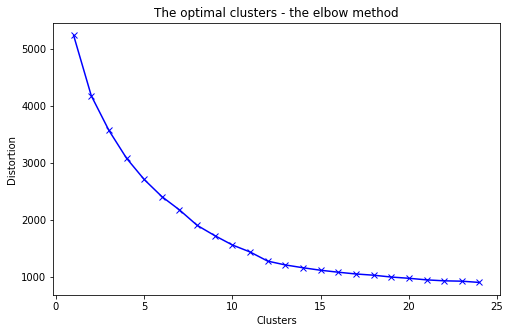

In [254]:
# Using the Elbow Method to find the optimal number of clusters (topics)
distortions = []
K = range(1,25)
for k in K:
 kmeanModel = KMeans(n_clusters=k)
 kmeanModel.fit(tweet_topic_matrix_ix)
 distortions.append(kmeanModel.inertia_)
 
plt.figure(figsize=(8,5))
plt.plot(K, distortions, 'bx-')
plt.xlabel('Clusters')
plt.ylabel('Distortion')
plt.title('The optimal clusters - the elbow method')
plt.show()

The above graph flattens out after ~12 (where the elbow is). Therefore, we have chosen 12 clusters.





In [255]:
# Creating optimal amount of clusters (topics)
clusterer = KMeans(n_clusters = 12)
clusterer.fit(tweet_topic_matrix_ix)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=12, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [256]:
#Importing seaborn for visualization
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


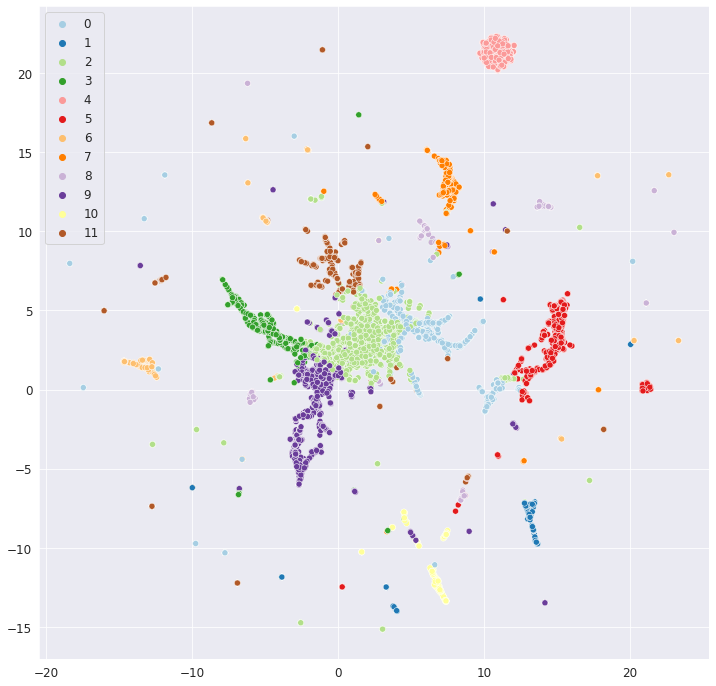

In [257]:
# Visualizing our clusters
sns.set_style("darkgrid")
 
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(12,12))
g = sns.scatterplot(*embeddings.T,
 hue=clusterer.labels_,
 palette="Paired",
 legend='full')

It does not seem like clusters can be clearly identified

In [258]:
# Write cluster-numbers into our data
elon_musk['cluster'] = clusterer.labels_

In [259]:
# Seems like cluster 5 is about Tesla
elon_musk[elon_musk['cluster'] == 5]['tokens']

date
2020-11-16    [whatsupfranks, michaelminalab, curevac, moder...
2020-11-10                              [teslany, tesla, happy]
2020-11-09    [samtalkstesla, tesla, important, product, wor...
2020-11-09    [samtalkstesla, tesla, tesla, rna, bioreactor,...
2020-11-09        [edspartan117, tesla, nykchannel, cybertruck]
                                    ...                        
2016-02-10           [tesla, motors, short, movie, independent]
2016-02-10                                       [tesla, video]
2016-01-10    [first, baby, step, tesla, summon, capability,...
2015-12-19    [article, tesla, california, taxis, net, rebat...
2015-11-20    [autopilot, software, team, tesla, full, auton...
Name: tokens, Length: 857, dtype: object

##Visualize top words in "Tesla" cluster

In [ ]:
# Install packages for making word cloud
!pip install wordcloud
from wordcloud import WordCloud, STOPWORDS

# Install packages for mask setting
from PIL import Image
import urllib.request

In [261]:
# Let's make a string of the most mentioned words in this cluster
tesla_cluster =elon_musk[elon_musk['cluster'] == 5]['tokens'].tolist()

tesla_str = " ".join(str(v) for v in tesla_cluster)

# Remove ""
tesla_str = tesla_str.replace("'",'')

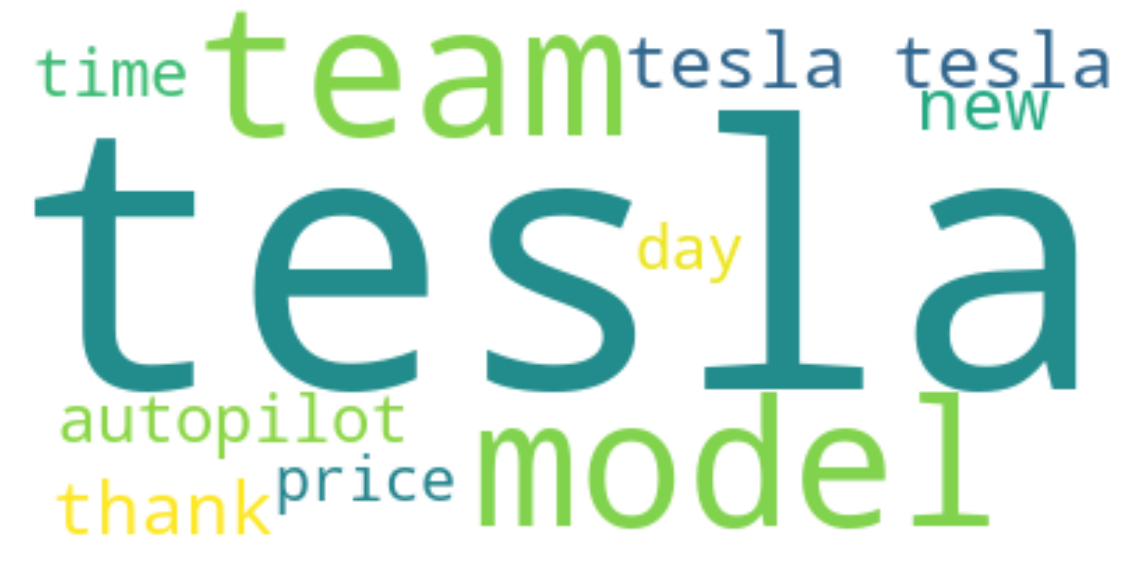

In [262]:
# Visualize wordcloud (note we now use stopwords to get the most important words)

wc = WordCloud(
    background_color="white",
    max_words=10, max_font_size=256,
    random_state=10,
    stopwords = stop_words)
wc.generate(tesla_str)
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.show()

**Convert to PDF**

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

In [93]:
%%capture 
!wget -nc https://raw.githubusercontent.com/brpy/colab-pdf/master/colab_pdf.py 
from colab_pdf import colab_pdf 
colab_pdf('Topic_Modelling.ipynb')